## Below code is to train a 32x32 dataset, using the data in the CIFAKE dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# --- 1. Data Loading & Preparation ---

# Define data paths and parameters
data_dir = os.path.join('data')
train_dir = os.path.join(data_dir, 'train')

IMG_WIDTH = 32
IMG_HEIGHT = 32
BATCH_SIZE = 64

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,  # Use 20% of training data for validation
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

# Load the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

# Get the class names (should be ['FAKE', 'REAL'])
class_names = train_ds.class_names
print("Class names:", class_names)

# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# --- 2. Function to Plot Training History ---

def plot_history(history, title):
    """Plots accuracy and loss curves for a given training history."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Training and Validation Loss')
    
    plt.show()

# --- 3. Model 1: CNN Baseline (3-4 Conv Layers) ---

print("\n--- Training Model 1: Simple CNN Baseline ---")

# This is a binary classification (FAKE vs. REAL), so we use 1 output neuron
# with a 'sigmoid' activation.
num_classes = 1 

model_cnn = keras.Sequential([
    # Input layer: Rescale pixel values from [0, 255] to [0, 1]
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the 3D feature maps to 1D
    layers.Flatten(),
    
    # Dense classifier layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(num_classes, activation='sigmoid') # Sigmoid for binary output
])

# Compile the model
model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

# Train the model
epochs = 20
history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Plot the results
plot_history(history_cnn, "Simple CNN")

# --- 4. Evaluate on Test Set ---
print("\n--- Evaluating on Test Set ---")
test_dir = os.path.join(data_dir, 'test')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
).cache().prefetch(buffer_size=AUTOTUNE)

test_loss, test_acc = model_cnn.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

# --- 5. Save the Trained Model ---
model_save_path = 'cifake_cnn_model.keras'
model_cnn.save(model_save_path)
print(f"\nModel saved to {model_save_path}")

## Below is code to pull a random image, red is wrong, blue is correct

Loading model from cifake_cnn_model.keras...
Model loaded successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,066,949 (4.07 MB)

 Trainable params: 355,649 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 711,300 (2.71 MB)

Found class names: ['FAKE', 'REAL']
Found 20000 files belonging to 2 classes.

--- Pulling a random image ---


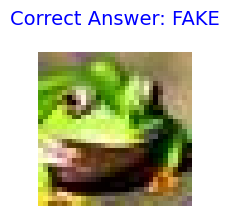

In [89]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np

# --- 1. Configuration ---
MODEL_PATH = 'cifake_cnn_model.keras'
data_dir = os.path.join('data')
test_dir = os.path.join(data_dir, 'test')
train_dir = os.path.join(data_dir, 'train') # Needed to get class names

IMG_WIDTH = 32
IMG_HEIGHT = 32
BATCH_SIZE = 64

# --- 2. Load Model ---
print(f"Loading model from {MODEL_PATH}...")
try:
    model = keras.models.load_model(MODEL_PATH)
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please make sure you have run the 'train_cnn.py' script first.")
    exit()

print("Model loaded successfully.")
model.summary()

# --- 3. Load Test Data and Class Names ---

# We need the class_names. The easiest way is to quickly load
# the training directory to see the folder names.
try:
    class_names = sorted(os.listdir(train_dir))
    if 'FAKE' not in class_names or 'REAL' not in class_names:
        raise Exception("Could not find 'FAKE' and 'REAL' folders.")
    print(f"Found class names: {class_names}")
except Exception as e:
    print(f"Error finding class names in {train_dir}: {e}")
    print("Please ensure the 'data/train' directory exists and has FAKE/REAL subfolders.")
    exit()


# Load the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True # Shuffle so we can just take 1 batch
)

# Configure for performance
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# --- 4. Get a Random Image and Predict ---

print("\n--- Pulling a random image ---")

# Take one batch from the shuffled test set
for images, labels in test_ds.take(1):
    # Get the first image and label from the batch
    image_to_show = images[0]
    true_label_index = labels[0].numpy() # Get the numpy value
    
    # Convert image for plotting (from [0,255] float to uint8)
    image_to_plot = image_to_show.numpy().astype("uint8")
    
    # Model expects a batch, so add a batch dimension
    image_to_predict = tf.expand_dims(image_to_show, 0) 
    
    # Get prediction (output is sigmoid, 0.0 to 1.0)
    # [0][0] selects the score from the batch and neuron
    pred_score = model.predict(image_to_predict, verbose=0)[0][0]
    
    # --- Helper function to turn prediction (0.0 - 1.0) into a class name ---
    def get_prediction_label(score, threshold=0.5):
        # class_names[0] is 'FAKE' (index 0)
        # class_names[1] is 'REAL' (index 1)
        if score > threshold:
            return class_names[1] # 'REAL'
        else:
            return class_names[0] # 'FAKE'

    # Get the string labels
    true_label = class_names[true_label_index]
    pred_label = get_prediction_label(pred_score)
    
    # --- 5. Plot the Results ---
    plt.figure(figsize=(2, 2))
    plt.imshow(image_to_plot)
    plt.axis('off')
    
    # Set title color based on correctness
    title_color = 'blue' if pred_label == true_label else 'red'
    
    # Display the true label and the model's prediction
    plt.title(f"Correct Answer: {true_label}", fontsize=14, pad=20, color = title_color)
    plt.xlabel(
        f"Model's Guess: {pred_label}\n"
        f"(Confidence Score: {pred_score:.3f})",
        fontsize=12,
        color=title_color,
        linespacing=1.5
    )
    
    # This line is important for showing the plot
    plt.show()
    
    # Stop after one image
    break

## Working on this for a 224x224 image classifier